# Handout #4: Unsupervised Learning (hierarchical clustering)

In [1]:
import numpy as np
from sklearn import cluster
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
group = '03' # assuming group 1
ds = 5 # assuming problems 5
data = np.loadtxt(f'ds{group}{str(ds)}.txt')
X = data[:, 0:2]
y = data[:, 2]

## Pintado de datos con etiquetas originales 

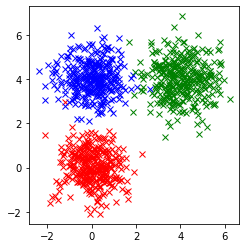

In [3]:
def draw_dataset(data):
    plt.subplot(111,aspect=1)
    w_0 = data[data[:,2] == 0]
    w_1 = data[data[:,2] == 1]
    w_2 = data[data[:,2] == 2]
    plt.plot(w_0[:,0], w_0[:,1], 'rx')
    plt.plot(w_1[:,0], w_1[:,1], 'bx');
    plt.plot(w_2[:,0], w_2[:,1], 'gx');
    
draw_dataset(data)

### Funciones auxiliares

In [4]:
# Dado un dataset, lo clusteriza mediante average/complete/ward linkage y muestra los resultados para 
# cada número de clusters dado por number_of_cluster_list
def do_clustering_and_plot(data, number_of_cluster_list, clustering_models_by_n):
    i = 0
    
    # Escalamos los datos
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)

    for n_clusters in number_of_cluster_list:
        # Inicialización de los modelos de clustering
        complete = cluster.AgglomerativeClustering(
            n_clusters = n_clusters, linkage = "complete"
        )
        ward = cluster.AgglomerativeClustering(
            n_clusters = n_clusters, linkage = "ward"
        )
        average = cluster.AgglomerativeClustering(
            n_clusters = n_clusters, linkage = "average"
        )

        clustering_algorithms = (
            ("Average Linkage", average),
            ("Complete Linkage", complete),
            ("Ward Linkage", ward)
        )

        # Guardamos los modelos
        clustering_models_by_n[n_clusters] = clustering_algorithms

        f, axs = plt.subplots(1, len(clustering_algorithms), figsize = (15, 5))
        f.tight_layout()

        j = 0

        for name, model in clustering_algorithms:
            model.fit(data)
            labels = model.labels_   
            distinct_labels = list(set(labels))

            # Pintamos el resultado, mostrando una fila por nº de clusters y una columna por algoritmo
            for label in distinct_labels:
                if i == 0:
                    axs[j].set_title(name)

                if j == 0:
                    axs[j].set(ylabel = str(n_clusters) + ' clusters')

                axs[j].scatter(data[labels == label, 0], data[labels == label, 1], s = 10, marker = 'x', color = np.random.rand(3,))

            j = j + 1
        i = i + 1

In [5]:
# Muestra las scores de cada combinación de modelo y nº de clusters.
# "clustering_models_by_n" es un diccionario de tuplas donde la key
# es el nº de clusters y las tuplas contienen el nombre del algoritmo de clustering
# utilizado y el modelo
def print_scores(clustering_models_by_n, X, y, measure):
    # Iteramos sobre los modelos almacenados en clustering_models_by_n
    for n_clusters, clustering_algorithms in clustering_models_by_n.items():
        print(f'{str(n_clusters)} clusters:')
        for name, model in clustering_algorithms:
            if measure == "v_score":
                score = v_measure_score(y, model.labels_)
            if measure == "db_score":
                score = davies_bouldin_score(X, model.labels_)

            print(f'\t{name}: {str(score)}')

        print()

In [6]:
# Dado un diccionario de modelos, este método muestra el nº de clusters más óptimo para cada tipo de algoritmo
def print_optimal_n_clusters(clustering_models_by_n, X, y, measure):   
    # Creamos un diccionario cuya key será el modelo y su valor una tupla con el
    # número de clusters más óptimo y su score
    best_n_clusters_by_model = {}

    for n_clusters, clustering_algorithms in clustering_models_by_n.items():
        for name, model in clustering_algorithms:    
            if measure == "v_score":
                score = v_measure_score(y, model.labels_)
            if measure == "db_score":
                score = davies_bouldin_score(X, model.labels_)
            
            if name not in best_n_clusters_by_model:
                # Inicializamos el diccionario
                best_n_clusters_by_model[name] = (n_clusters, score) 
            else:
                # Si es mejor candidato, lo añadimos al diccionario
                if measure == "v_score":
                    # Cuanto más alto es el valor del V measure, más homogeneos y completos serán los clusters
                    # (recordemos que es la media harmónica entre las medidas de completitud y homogeneidad)
                    if best_n_clusters_by_model[name][1] < score:
                        best_n_clusters_by_model[name] = (n_clusters, score)
                if measure == "db_score":
                    # Cuanto más bajo es el valor del índice de Davies Bouldin, más compactos serán los 
                    # clusters y más separados entre sí, por lo tanto cogeremos el valor más pequeño
                    if best_n_clusters_by_model[name][1] > score:
                        best_n_clusters_by_model[name] = (n_clusters, score)

    # Mostramos el resultado
    for name, tuple in best_n_clusters_by_model.items():
        print(f'{name}: {tuple[0]} clusters (score = {tuple[1]})')
        
    return best_n_clusters_by_model

In [7]:
# Esta función recibe por parámetro el valor retornado por la función print_optimal_n_clusters()
# y obtiene el mejor de los modelos y nº de clusters entre los candidatos
def print_optimal_model(best_n_clusters_by_model, measure):
    best_result = ()

    for name, tuple in best_n_clusters_by_model.items():
        if not best_result:
            # Si aún no tenemos candidato, añadimos el actual
            best_result = (name, tuple[0], tuple[1])
        else:
            # Si el resultado es más óptimo lo guardamos en best_result
            if measure == "v_score":
                if best_result[2] < tuple[1]:
                    best_result = (name, tuple[0], tuple[1])
            if measure == "db_score":
                if best_result[2] > tuple[1]:
                    best_result = (name, tuple[0], tuple[1])
                    
    optimal_algorithm_name = best_result[0]
    optimal_n_clusters = best_result[1]
    optimal_score = best_result[2]

    print(f"El mejor algoritmo es {optimal_algorithm_name}, con {optimal_n_clusters} clusters y una puntuación de {optimal_score}")
    
    return (optimal_algorithm_name, optimal_n_clusters, optimal_score)

In [8]:
# Dibuja un plot con las clases originales y otro con las predicciones
def plot_original_and_predicted_data(optimal_algorithm_name, optimal_n_clusters, optimal_score, X, y):
    f, axs = plt.subplots(1, 2, figsize = (15, 5))
    f.tight_layout()

    # Recuperamos el modelo que corresponde al mejor resultado
    optimal_model = clustering_models_by_n[optimal_n_clusters][[0] == optimal_algorithm_name][1]
    optimal_labels = optimal_model.labels_
    distinct_labels = list(set(y))

    for label in distinct_labels:
        # Etiquetas reales
        axs[0].scatter(X[y == label, 0], X[y == label, 1], s = 10, marker = 'x', color = np.random.rand(3,))
        axs[0].set_title("True labelling")

        # Etiquetas provenientes del modelo
        axs[1].scatter(X[optimal_labels == label, 0], X[optimal_labels == label, 1], s = 10, marker = 'x', color = np.random.rand(3,))
        axs[1].set_title("Model")
        
    return optimal_labels

## Soluciones

**P5. Given the dataset dsxx5.txt, cluster it according to the following combinations:**
- **the complete linkage, the average linkage and the ward algorithms,**
- **2, 3, 4, and 5 clusters, and**
- **the Euclidean distance**

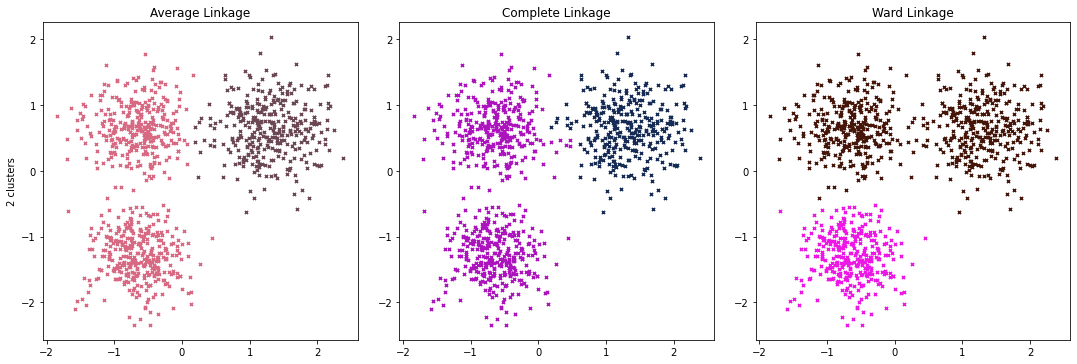

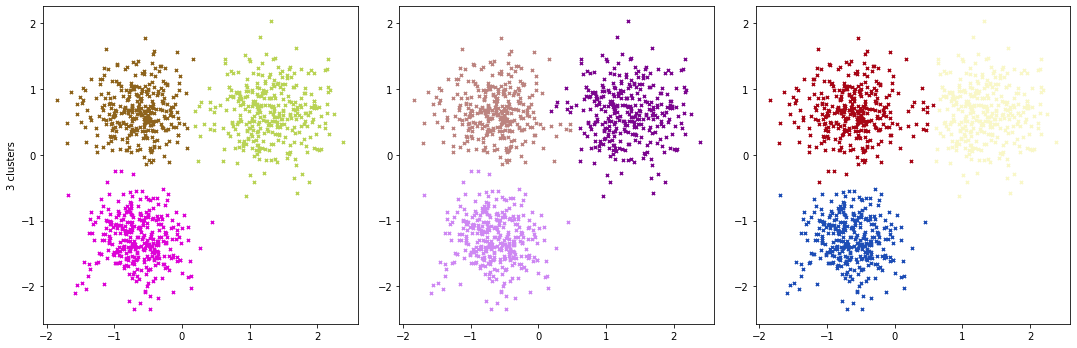

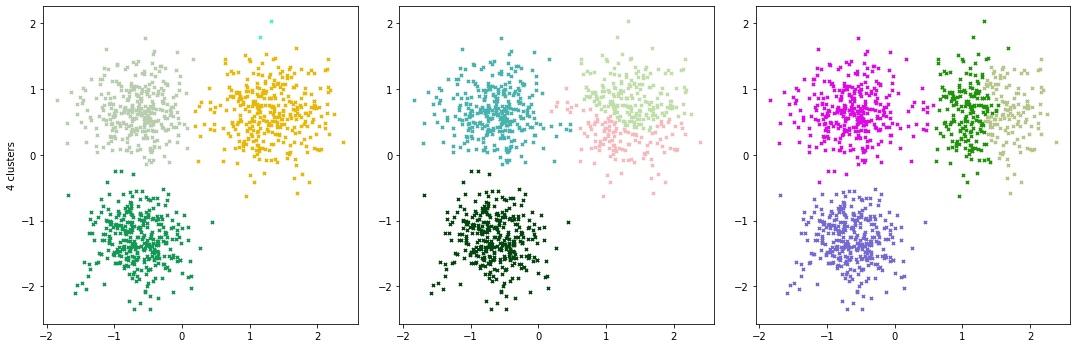

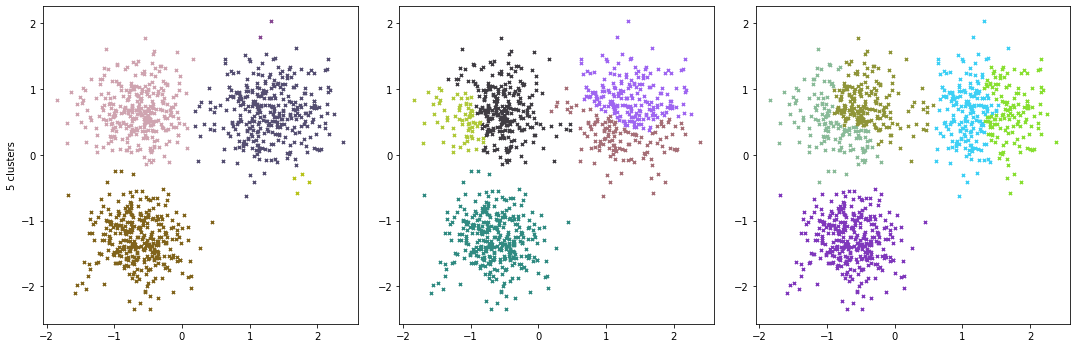

In [9]:
number_of_cluster_list = [2, 3, 4, 5]

# Almacenaremos los modelos en este diccionario para su posterior uso en los diferentes apartados
clustering_models_by_n = {}

do_clustering_and_plot(X, number_of_cluster_list, clustering_models_by_n)

**(a) considering the V-measure (external measure):**

**i) calculate the metric value for all cases**

In [10]:
print_scores(clustering_models_by_n, X, y, "v_score")

2 clusters:
	Average Linkage: 0.697801838383488
	Complete Linkage: 0.6775428164140035
	Ward Linkage: 0.7188985898279532

3 clusters:
	Average Linkage: 0.9483994093801746
	Complete Linkage: 0.9353085598774898
	Ward Linkage: 0.9324485630270858

4 clusters:
	Average Linkage: 0.9431690043008554
	Complete Linkage: 0.8524199717742938
	Ward Linkage: 0.8483612720777998

5 clusters:
	Average Linkage: 0.9340550620342164
	Complete Linkage: 0.7982617803577989
	Ward Linkage: 0.7798802504073585



**ii) select the best number of clusters according to this metric for each algorithm**

In [11]:
best_n_clusters_by_model = print_optimal_n_clusters(clustering_models_by_n, X, y, "v_score")

Average Linkage: 3 clusters (score = 0.9483994093801746)
Complete Linkage: 3 clusters (score = 0.9353085598774898)
Ward Linkage: 3 clusters (score = 0.9324485630270858)


**iii) select the best algorithm and number of clusters according to this metric**

In [12]:
(optimal_algorithm_name, optimal_n_clusters, optimal_score) = print_optimal_model(best_n_clusters_by_model, "v_score")

El mejor algoritmo es Average Linkage, con 3 clusters y una puntuación de 0.9483994093801746


**iv) plot separately the dataset using the true labelling and the labelling derived from the best algorithm
and number of clusters**

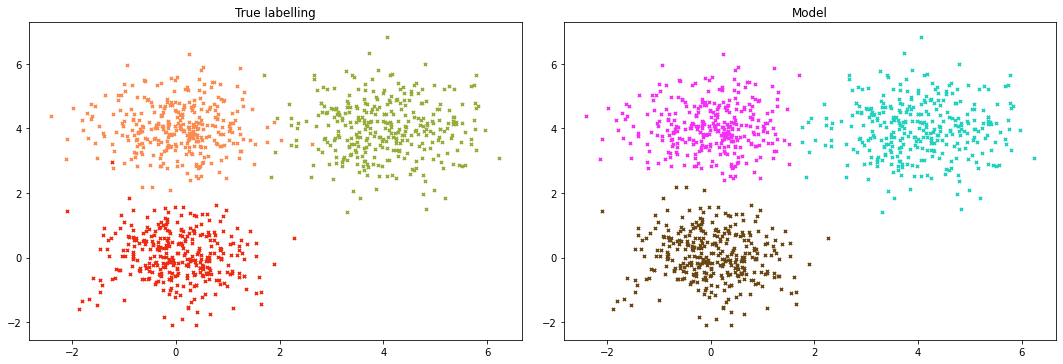

In [13]:
optimal_labels = plot_original_and_predicted_data(optimal_algorithm_name, optimal_n_clusters, optimal_score, X, y)

**v) find the contingency table for the best algorithm and number of clusters, and**

In [14]:
contingency_matrix(y, optimal_labels)

array([[  0, 333,   1],
       [  5,   3, 325],
       [332,   0,   1]])

**vi) determine the asignment of classes to clusters and the number of clustering errors that result from the
best algorithm and number of clusters;**

La matriz de contingencia nos muestra las clases reales por fila y los clusters por columna. En el resultado de clustering más óptimo coincide el número de clases con el número de clusters, lo que es buena señal. En la matriz podemos observar que la clase 1 ha sido asignada mayoritariamente al cluster 3, la clase 2 al cluster 2 y la clase 3 al cluster 1.

In [15]:
# Homogeneidad
print(f"Homogeneidad: {homogeneity_score(y, optimal_labels)}")
# Completitud
print(f"Completitud: {completeness_score(y, optimal_labels)}")

Homogeneidad: 0.9483604399493536
Completitud: 0.9484383820137422


La homogeneidad indica cómo de homogeneos son los clusters, es decir, el número de clases reales que abarca. El resultado es muy cercano a 1, lo que indica que los clusters no mezclan clases dentro de ellos

La completitud indica cómo de repartida ha sido una clase entre los diferentes clusters. Cuanto más contenida en un único cluster esté cada clase, mayor completitud obtendremos. En este caso el resultado es cercano a 1, lo que indica que las clases están bien definidas en los clusters creados.

En cuanto a los errores de asignación, podemos observar que:

la clase 1 tiene 1 error de asignación
la clase 2 tiene 8 errores de asignación
la clase 3 tiene 1 error de asignación

**(b) considering the Davies-Bouldin score (internal measure):**

**i) calculate the metric value for all cases**

In [16]:
print_scores(clustering_models_by_n, X, y, "db_score")

2 clusters:
	Average Linkage: 0.7306341641931422
	Complete Linkage: 0.7238673240262398
	Ward Linkage: 0.6973459624234714

3 clusters:
	Average Linkage: 0.49371549280209454
	Complete Linkage: 0.4970075304898515
	Ward Linkage: 0.5015900980169835

4 clusters:
	Average Linkage: 0.5112668723065515
	Complete Linkage: 0.9297820526997115
	Ward Linkage: 0.8945096330010206

5 clusters:
	Average Linkage: 0.5319405513710089
	Complete Linkage: 1.0613367999583319
	Ward Linkage: 1.167579207560697



**ii) select the best number of clusters according to this metric for each algorithm**

In [17]:
best_n_clusters_by_model = print_optimal_n_clusters(clustering_models_by_n, X, y, "db_score")

Average Linkage: 3 clusters (score = 0.49371549280209454)
Complete Linkage: 3 clusters (score = 0.4970075304898515)
Ward Linkage: 3 clusters (score = 0.5015900980169835)


**iii) select the best algorithm and number of clusters according to this metric**

In [18]:
(optimal_algorithm_name, optimal_n_clusters, optimal_score) = print_optimal_model(best_n_clusters_by_model, "db_score")

El mejor algoritmo es Average Linkage, con 3 clusters y una puntuación de 0.49371549280209454


**iv) plot separately the dataset using the true labelling and the labelling derived from the best algorithm
and number of clusters**

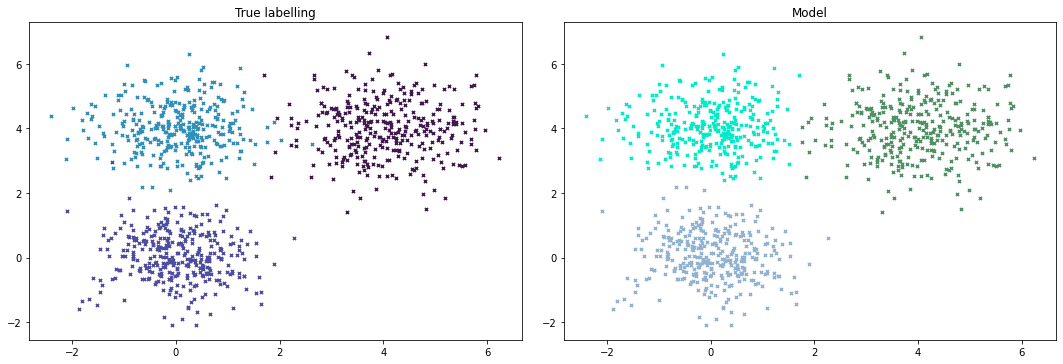

In [19]:
optimal_labels = plot_original_and_predicted_data(optimal_algorithm_name, optimal_n_clusters, optimal_score, X, y)

**v) find the contingency table for the best algorithm and number of clusters**

In [20]:
contingency_matrix(y, optimal_labels)

array([[  0, 333,   1],
       [  5,   3, 325],
       [332,   0,   1]])

**vi) determine the asignment of classes to clusters and the number of clustering errors that result from the
best algorithm and number of clusters.**

El resultado es idéntico al mismo ejercicio del apartado a)

**To finish, using one or two paragraphs, comment on whatever you consider adequate regarding the results
obtained, e.g. a certain score is not indicating the real number of clusters and why, whether the mistakes are
relevant or can be accepted, what should be discarded to get an acceptable result, etc**

Ambos índices coinciden en que la solución más óptima es usar el algoritmo Average Linkage, usando 3 clusters, a pesar de que se fijan en cosas distintas (v-measure en homogeneidad y completitud, mientras que dbouldin en lo compactos y separados entre si que son los clusters). Esto da más seguridad a la hora de escoger la solución final. Además, el número de clusters resultante coincide con el número de clases reales encontradas, lo que da más firmeza a la correctitud de la solución.

Como hemos visto, tenemos una completitud de 0.9484 y una homogeneidad de 0.9483. Es un porcentaje de acierto muy bueno, pero solo sería útil para aplicaciones con cierta tolerancia a fallos. No hay ninguna clase contenida al 100% en un cluster ni ningún cluster que contenga el 100% de elementos de una única clase. 

**P6. Repeat problem P5 (except points a.iv and b.iv) using the digits dataset directly available from scikit5**

In [21]:
digits, labels = load_digits(return_X_y = True)
indexes = np.concatenate((np.where(labels == 6)[0], np.where(labels == 7)[0], np.where(labels == 8)[0]))
reduced_X = [digits[i] for i in indexes]
reduced_y = [labels[i] for i in indexes]

- **the complete linkage, the average linkage and the ward algorithms,**
- **2, 3, 4, and 5 clusters, and**
- **the Euclidean distance**

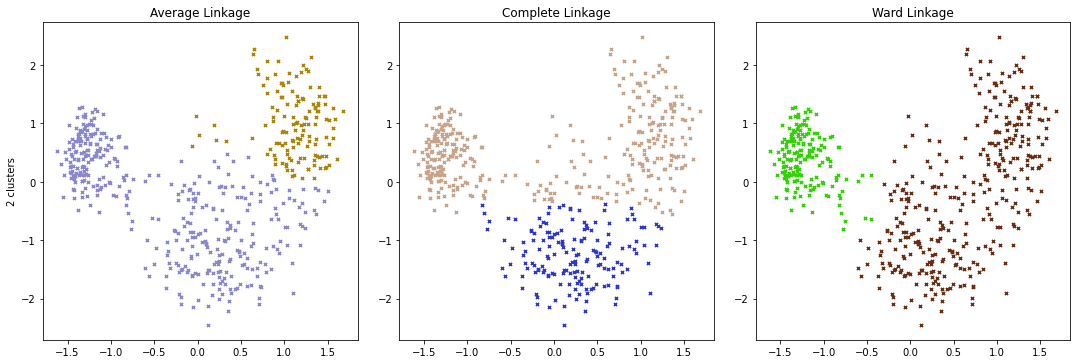

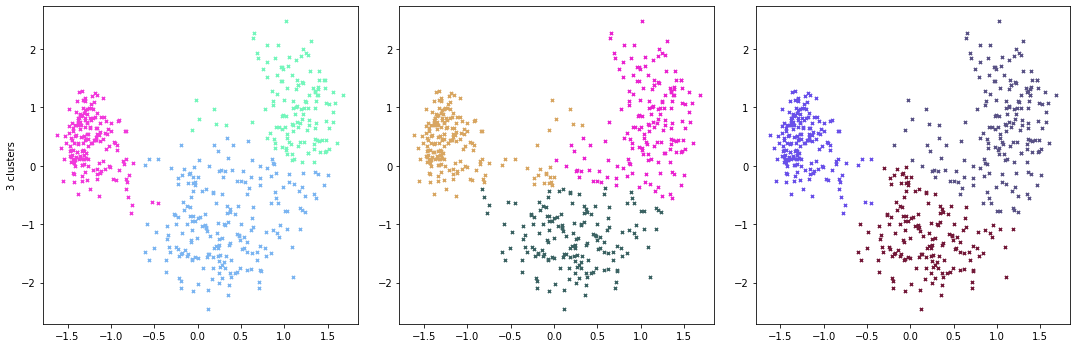

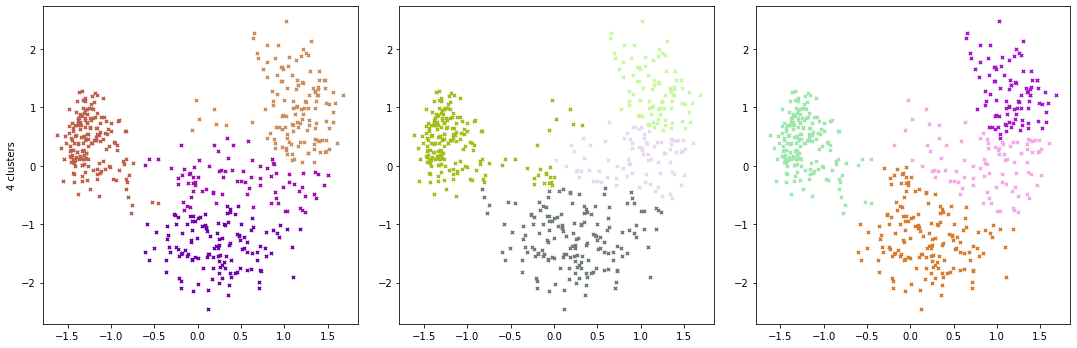

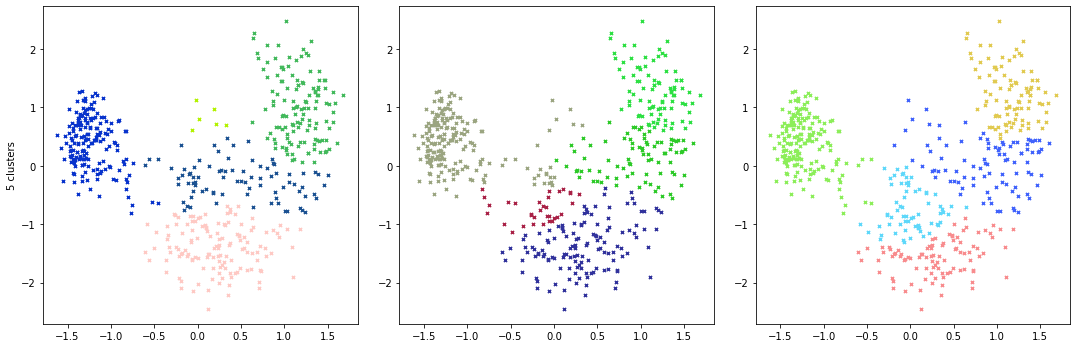

In [22]:
# Usamos PCA para reducir el problema a 2 dimensiones y poder visualizar los clusters
reduced_X = PCA(n_components = 2).fit_transform(reduced_X)

# Almacenaremos los modelos en este diccionario para su posterior uso en los diferentes apartados
clustering_models_by_n = {}

do_clustering_and_plot(reduced_X, number_of_cluster_list, clustering_models_by_n)

**(a) considering the V-measure (external measure):**

**i) calculate the metric value for all cases**

In [23]:
print_scores(clustering_models_by_n, reduced_X, reduced_y, "v_score")

2 clusters:
	Average Linkage: 0.3768665811971011
	Complete Linkage: 0.33519637586978596
	Ward Linkage: 0.6923913946576615

3 clusters:
	Average Linkage: 0.7002974854934179
	Complete Linkage: 0.6547812738976994
	Ward Linkage: 0.7646094147982682

4 clusters:
	Average Linkage: 0.6599258718777926
	Complete Linkage: 0.6151006898569148
	Ward Linkage: 0.7160140005059528

5 clusters:
	Average Linkage: 0.6803315987787869
	Complete Linkage: 0.5932634441499032
	Ward Linkage: 0.6650294665938318



**ii) select the best number of clusters according to this metric for each algorithm**

In [24]:
best_n_clusters_by_model = print_optimal_n_clusters(clustering_models_by_n, reduced_X, reduced_y, "v_score")

Average Linkage: 3 clusters (score = 0.7002974854934179)
Complete Linkage: 3 clusters (score = 0.6547812738976994)
Ward Linkage: 3 clusters (score = 0.7646094147982682)


**iii) select the best algorithm and number of clusters according to this metric**

In [25]:
(optimal_algorithm_name, optimal_n_clusters, optimal_score) = print_optimal_model(best_n_clusters_by_model, "v_score")

El mejor algoritmo es Ward Linkage, con 3 clusters y una puntuación de 0.7646094147982682


**v) find the contingency table for the best algorithm and number of clusters**

In [26]:
# Recuperamos el modelo que corresponde al mejor resultado
optimal_model = clustering_models_by_n[optimal_n_clusters][[0] == optimal_algorithm_name][1]
optimal_labels = optimal_model.labels_

contingency_matrix(reduced_y, optimal_labels)

array([[  4,   0, 177],
       [ 50, 129,   0],
       [164,   7,   3]])

**vi) determine the asignment of classes to clusters and the number of clustering errors that result from the
best algorithm and number of clusters.**

La matriz de contingencia nos muestra las clases reales por fila y los clusters por columna. En el resultado de clustering más óptimo coincide el número de clases con el número de clusters, lo que es buena señal. En la matriz podemos observar que la clase 1 ha sido asignada mayoritariamente al cluster 3, la clase 2 al cluster 2 y la clase 3 al cluster 1.

In [27]:
# Homogeneidad
print(f"Homogeneidad: {homogeneity_score(reduced_y, optimal_labels)}")
# Completitud
print(f"Completitud: {completeness_score(reduced_y, optimal_labels)}")

Homogeneidad: 0.6946102192787875
Completitud: 0.7060786518948609


Tanto homogeneidad como completitud se acercan ligeramente a 1, por lo que el resultado no es malo, aunque le falta bastante para ser fiable.

En cuanto a los errores de asignación, podemos observar que:

- la clase 1 tiene 4 errores de asignación
- la clase 2 tiene 50 errores de asignación
- la clase 3 tiene 10 error de asignación

**(b) considering the Davies-Bouldin score (internal measure):**

**i) calculate the metric value for all cases**

In [28]:
print_scores(clustering_models_by_n, reduced_X, reduced_y, "db_score")

2 clusters:
	Average Linkage: 0.7939828021426167
	Complete Linkage: 1.4710635681253195
	Ward Linkage: 0.5874454633020825

3 clusters:
	Average Linkage: 0.6185386822942668
	Complete Linkage: 0.608323142412242
	Ward Linkage: 0.6042857004644021

4 clusters:
	Average Linkage: 0.9851227562074312
	Complete Linkage: 0.8135703705206405
	Ward Linkage: 0.8384526289244595

5 clusters:
	Average Linkage: 0.9626831827094545
	Complete Linkage: 0.9409779738856241
	Ward Linkage: 0.9618510066012332



**ii) select the best number of clusters according to this metric for each algorithm**

In [29]:
best_n_clusters_by_model = print_optimal_n_clusters(clustering_models_by_n, reduced_X, reduced_y, "db_score")

Average Linkage: 3 clusters (score = 0.6185386822942668)
Complete Linkage: 3 clusters (score = 0.608323142412242)
Ward Linkage: 2 clusters (score = 0.5874454633020825)


**iii) select the best algorithm and number of clusters according to this metric**

In [30]:
(optimal_algorithm_name, optimal_n_clusters, optimal_score) = print_optimal_model(best_n_clusters_by_model, "v_score")

El mejor algoritmo es Average Linkage, con 3 clusters y una puntuación de 0.6185386822942668


**v) find the contingency table for the best algorithm and number of clusters**

In [31]:
# Recuperamos el modelo que corresponde al mejor resultado
optimal_model = clustering_models_by_n[optimal_n_clusters][[0] == optimal_algorithm_name][1]
optimal_labels = optimal_model.labels_

contingency_matrix(reduced_y, optimal_labels)

array([[  4,   0, 177],
       [ 50, 129,   0],
       [164,   7,   3]])

**vi) determine the asignment of classes to clusters and the number of clustering errors that result from the
best algorithm and number of clusters.**

La matriz de contingencia nos muestra las clases reales por fila y los clusters por columna. En el resultado de clustering más óptimo coincide el número de clases con el número de clusters, lo que es buena señal. En la matriz podemos observar que la clase 1 ha sido asignada mayoritariamente al cluster 3, la clase 2 al cluster 2 y la clase 3 al cluster 1.

In [32]:
# Homogeneidad
print(f"Homogeneidad: {homogeneity_score(reduced_y, optimal_labels)}")
# Completitud
print(f"Completitud: {completeness_score(reduced_y, optimal_labels)}")

Homogeneidad: 0.6946102192787875
Completitud: 0.7060786518948609


Tanto homogeneidad como completitud se acercan ligeramente a 1, por lo que el resultado no es malo, aunque le falta bastante para ser fiable.

En cuanto a los errores de asignación, podemos observar que:


- la clase 1 tiene 4 errores de asignación
- la clase 2 tiene 50 errores de asignación
- la clase 3 tiene 10 error de asignación

**To finish, using one or two paragraphs, comment on whatever you consider adequate regarding the results
obtained, e.g. a certain score is not indicating the real number of clusters and why, whether the mistakes are
relevant or can be accepted, what should be discarded to get an acceptable result, etc**

Esta vez no hay consenso en el algoritmo a usar: V-measure nos indica que Ward Linkage es la mejor opción para realizar los clusters, mientras que Davies Bouldin dice que el mejor algoritmo es Average Linkage. Donde sí coinciden es en el número de clusters, donde ambos han acertado ya que el número de clases reales son 3.

En cuanto a homogeneidad y completitud, ambas son inferiores a las obtenidas en P5. Esto es debido a que las clases están mucho menos separadas que en aquel ejemplo, donde la separación era clara. Esto puede deberse al parecido entre los números y a las irregularidades al dibujarlos. Tanto en Ward como en Average Linkage la tabla de contingencia es casualmente idéntica, por lo que tenemos los mismos valores de homogeneidad y completitud. Este porcentaje de acierto es relativamente bueno, pero tal cantidad de errores nos hacen pensar que hay algoritmos mejores para el reconocimiento de caracteres alfanuméricos escritos a mano.

Con la duda de si el resultado no era bueno del todo por el parecido entre los números 6 y 8 se ha probado a cambiar las clases cogidas del datasaet, pero el resultado sigue sin ser satisfactorio del todo. Igualmente, s